In [1]:
import pandas as pd
from arch import arch_model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import  mean_squared_error

R =pd.read_csv('../TD4/long_series_logret.csv',index_col=0)
R.index = pd.DatetimeIndex(R.index)

year = 252
r = (R[R.index.year>2005].values*year).T[0] #Just for convinience I annualized the returns

In [2]:
#In-sample and out-of-sample window size
tin,tout = 1500,5

In [209]:
t = 0

#fitting and GARCH(1,1) on the in-sample window
Model = arch_model(r[t:t+tin], vol='GARCH', p=1,q=1,dist='t')
fit = Model.fit(disp='off')

#get the parameters
parms = fit.params

In [210]:
parms

mu          0.243070
omega       0.687305
alpha[1]    0.074552
beta[1]     0.918357
nu          5.472628
Name: params, dtype: float64

In [43]:
#Convergence value of the conditional variance
conv = parms.loc['omega']/(1-parms.loc['alpha[1]']-parms.loc['beta[1]'])

conv

96.92857292526473

In [211]:
# Forecast of  500 time step analytically

forecast = fit.forecast(horizon=500,method='analytic')

In [213]:
# Only the last row is the forecast, the columns are the lags
# The first element is the last in-sample estimate

forecast.variance

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.491,h.492,h.493,h.494,h.495,h.496,h.497,h.498,h.499,h.500
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


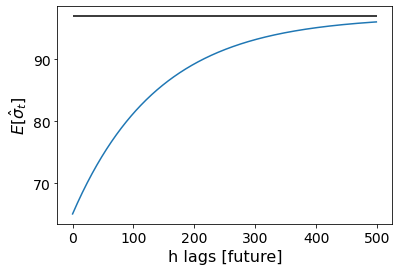

In [50]:
plt.plot( forecast.variance.iloc[-1].values )
plt.hlines(conv,0,500)
plt.xlabel('h lags [future]',fontsize=16)
plt.ylabel(r'$E[\hat{\sigma}_t]$',fontsize=16)
plt.tick_params(labelsize=14)

In [214]:
t = 0

# define a GARCH(1,1) for in-sample and out-of-sample
Model = arch_model(r[t:t+tin+tout], vol='GARCH', p=1,q=1,dist='t')
# fit only the in-sample time-window 
fit = Model.fit(disp='off',last_obs=tin)

# Simulate for the out-of-sample horizon, if 1000 sims are too much, just reduce it
forecast = fit.forecast(horizon=tout+1,simulations=1000,method='simulation')

In [216]:
#only the last element are the simulations
forecast.simulations.variances

array([[[         nan,          nan,          nan,          nan,
                  nan,          nan],
        [         nan,          nan,          nan,          nan,
                  nan,          nan],
        [         nan,          nan,          nan,          nan,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan,          nan,
                  nan,          nan],
        [         nan,          nan,          nan,          nan,
                  nan,          nan],
        [         nan,          nan,          nan,          nan,
                  nan,          nan]],

       [[         nan,          nan,          nan,          nan,
                  nan,          nan],
        [         nan,          nan,          nan,          nan,
                  nan,          nan],
        [         nan,          nan,          nan,          nan,
                  nan,          nan],
        ...,
        [         nan,          nan,         

In [218]:
# Simulations are by rows, times is by column. The first column is the last in-sample observation
forecast.simulations.variances[-1].shape

(1000, 6)

In [219]:
simulated = forecast.simulations.variances[-1][:,1:]

# Estimat the conditional variance by using the in-sample calibrated parameters
OOS_obs = Model.fix(fit.params).conditional_volatility[-tout:]**2
## fix computing overall the timeseries 

# Get a 90% confidence interval
minCI,maxCI = np.percentile(simulated,5,axis=0),np.percentile(simulated,95,axis=0)

# Get the mean (it can be computed also analytically)
mean = simulated.mean(axis=0)

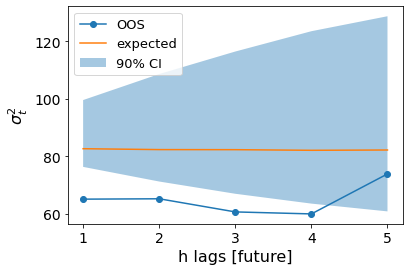

In [220]:

dx = np.arange(1,tout+1)
plt.plot(dx,OOS_obs,'-o',label='OOS --> variance prédites')
plt.fill_between(dx,minCI,maxCI,alpha=0.4,label='90% Confidance Interval')
plt.plot(dx,mean,label='expected --> variance moyenne sur les simulations Monte Carlo')
plt.xlabel('h lags [future]',fontsize=16)
plt.ylabel(r'$σ_t^2$',fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(loc='upper left',fontsize=13)

In [221]:
Coverage_GARCH,DIFF_GARCH = [],[]

# Sliding windows in step of 5 days
for t in range(0,1000,5):

    Model = arch_model(r[t:t+tin+tout], vol='GARCH', p=1,q=1,dist='t')
    fit = Model.fit(disp='off',last_obs=tin)
    
    #if 1000 are too much reduce it
    forecast = fit.forecast(horizon=tout+1,simulations=1000,method='simulation')

    simulated = forecast.simulations.variances[-1][:,1:]
    
    OOS_obs = Model.fix(fit.params).conditional_volatility[-tout:]**2


    minCI,maxCI = np.percentile(simulated,5,axis=0),np.percentile(simulated,95,axis=0)
    mean = simulated.mean(axis=0)

    # Computing if the observations fall inside the CI
    Coverage_GARCH.append( (OOS_obs>minCI)*(OOS_obs<maxCI) )
    
    # Computing the deviation from the expectation 
    DIFF_GARCH.append(OOS_obs-mean)

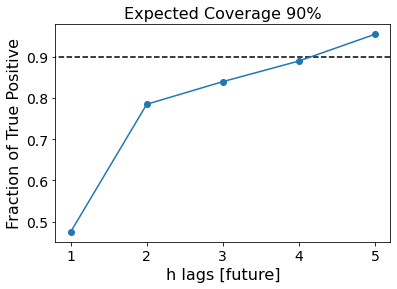

In [222]:
dx = np.arange(1,1+tout)
plt.plot(dx, np.mean(Coverage_GARCH,axis=0),'-o' )
plt.hlines(0.9,0,7,linestyles='--')
plt.xlim([0.8,5.2])
plt.xlabel('h lags [future]',fontsize=16)
plt.ylabel('Fraction of True Positive',fontsize=16)
plt.tick_params(labelsize=14)

plt.title('Expected Coverage 90%',fontsize=16)
plt.show()


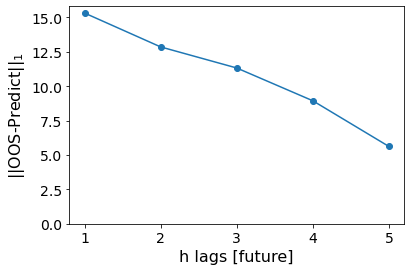

In [223]:
plt.plot( dx,abs(np.array(DIFF_GARCH)).mean(axis=0),'-o' ,label='GARCH(1,1)' )

plt.xlim([0.8,5.2])
plt.xlabel('h lags [future]',fontsize=16)
plt.ylabel(r'||OOS-Predict||$_1$',fontsize=16)
plt.tick_params(labelsize=14)

plt.ylim(ymin=0)
plt.show()

In [226]:
# The long-range predictions seems better


In [224]:
Coverage_ARCH,DIFF_ARCH = [],[]
for t in range(0,1000,5):

    #Fit with an ARCH(5)
    Model = arch_model(r[t:t+tin+tout], vol='ARCH', p=5,dist='t')
    fit = Model.fit(disp='off',last_obs=tin)
    
    #if 1000 are too much reduce it
    forecast = fit.forecast(horizon=tout+1,simulations=1000,method='simulation')

    simulated = forecast.simulations.variances[-1][:,1:]
    
    OOS_obs = Model.fix(fit.params).conditional_volatility[-tout:]**2

    
    minCI,maxCI = np.percentile(simulated,5,axis=0),np.percentile(simulated,95,axis=0)
    mean = simulated.mean(axis=0)

    Coverage_ARCH.append( (OOS_obs>minCI)*(OOS_obs<maxCI) )
    DIFF_ARCH.append(OOS_obs-mean)

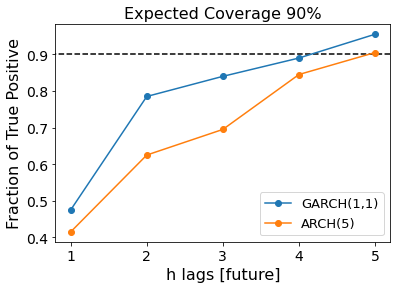

In [227]:
dx = np.arange(1,1+tout)
plt.plot(dx, np.mean(Coverage_GARCH,axis=0),'-o',label='GARCH(1,1)' )
plt.plot(dx, np.mean(Coverage_ARCH,axis=0),'-o',label='ARCH(5)' )
plt.hlines(0.9,0,7,linestyles='--')
plt.xlim([0.8,5.2])
plt.xlabel('h lags [future]',fontsize=16)
plt.ylabel('Fraction of True Positive',fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(loc='lower right',fontsize=13)
plt.title('Expected Coverage 90%',fontsize=16)
plt.show()

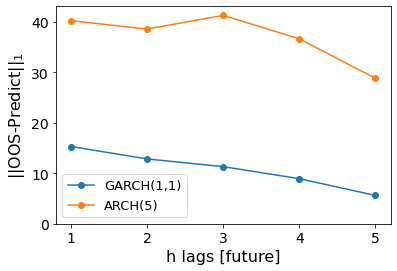

In [228]:
plt.plot( dx,abs(np.array(DIFF_GARCH)).mean(axis=0),'-o' ,label='GARCH(1,1)' )
plt.plot( dx,abs(np.array(DIFF_ARCH)).mean(axis=0),'-o' ,label='ARCH(5)' )

plt.xlim([0.8,5.2])
plt.xlabel('h lags [future]',fontsize=16)
plt.ylabel(r'||OOS-Predict||$_1$',fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(loc='best',fontsize=13)

plt.ylim(ymin=0)
plt.show()

In [229]:
# The GARCH(1,1) is clearly better then the ARCH(5)

In [ ]:
# Please note that this is only an anecdotal example, you should not never assume it as a general rule.